# Business Expansion Analysis.
**Data Notebook.**  
**Capstone Project - The Battle of Neighborhoods.**  
*by Luis Jacobo*  
04/27/2020

### Importing Libraries.

In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
from collections import defaultdict
import random
import requests
print('Libraries Imported')

Libraries Imported


### Installing necessary packages.

In [3]:
#!pip install lxml
#!pip install BeautifulSoup4
print('lxml and BeautifulSoup4 installed')

lxml and BeautifulSoup4 installed


### Get Data  
To get all the neighborhoods of the city of Santo Domingo, Distrito Nacional, i donwloaded a list from wikipedia link *https://en.wikipedia.org/wiki/Distrito_Nacional#Sectores_(neighborhoods)*.

In [4]:
url_sd = 'https://en.wikipedia.org/wiki/Distrito_Nacional#Sectores_(neighborhoods)'
hoods_sd = pd.read_html(url_sd)

In [5]:
sd_neigh = pd.DataFrame(hoods_sd[1])
sd_neigh = sd_neigh.rename(columns={'Sector': 'Neighborhood', 'Population[1]': 'Population'})
sd_neigh['Neighborhood'] = sd_neigh['Neighborhood'].astype(str) + ' Santo Domingo'
sd_neigh.head()

,Neighborhood,Population
0,Altos de Arroyo Hondo Santo Domingo,27692
1,Arroyo Manzano Santo Domingo,19151
2,Atala Santo Domingo,17617
3,Bella Vista Santo Domingo,28253
4,Buenos Aires-Independencia Santo Domingo,14759


### Adding Geolocation for Each Neighborhood.  
*First, we install the Geopy package in order to quey the Geolocation with the name of the neighborhood.*  
*Checking some neighborhoods, I noticed that the Geocoder Nominatim couldn't find someones, because of that i had to create a "Free Account" in  
Google Cloud Platform to use the Maps API*"  

*Be carefull, it is not free at all, they give you a $200 USD monthly credict.*

In [6]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import GoogleV3
print('Geopy library imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0

The following packages will be UPDATED:

  openssl                                 1.1.1f-h516909a_0 --> 1.1.1g-h516909a_0



openssl-1.1.1g       | 2.1 MB    | ############

### Getting Coordinates for Santo Domingo, Distrito Nacional and each Neighborhood.

In [7]:
sd_dn = 'Santo Domingo'
geolocator = GoogleV3(api_key='')
location = geolocator.geocode(sd_dn)
sd_latitude = location.latitude
sd_longitude = location.longitude
print('The coordinates of Santo Domingo, Distrito Nacional {}, {}.'.format(sd_latitude, sd_longitude))

The coordinates of Santo Domingo, Distrito Nacional 18.4860575, -69.93121169999999.


In [8]:
#Converting the neighborhoods to an array. 
hoods = pd.DataFrame(sd_neigh, columns = ['Neighborhood'])
hoods = np.array(hoods).ravel()

In [10]:
#Getting coordinates for each Neighborhood.
d = defaultdict(list)
for i in hoods:
    geolocator = GoogleV3(api_key='')
    location = geolocator.geocode(i)
    latitude = location.latitude
    longitude = location.longitude
    d['latitude'].append(location.latitude)
    d['longitude'].append(location.longitude)
    d['Neighbourhood'].append(i)
hoods_located = pd.DataFrame(d)

In [31]:
#Some housekeeping for the new dataframe and saving locally.
hoods_located.shape
hoods_located.to_csv('hoods_located.csv')

### Will create a new dataset as result of merging the Geolocation data with the neighborhoods. 

In [11]:
hoods_GeoLoc = sd_neigh.merge(hoods_located, how='left', left_on='Neighborhood', right_on='Neighbourhood')
hoods_GeoLoc.shape
hoods_GeoLoc.drop('Neighbourhood', axis=1, inplace=True)
hoods_GeoLoc.to_csv('hoods_GeoLoc.csv')
hoods_GeoLoc.tail()

,Neighborhood,Population,latitude,longitude
66,Villa Consuelo Santo Domingo,54065,18.484893,-69.898639
67,Villa Francisca Santo Domingo,49397,18.483282,-69.888477
68,Villa Juana Santo Domingo,46268,18.489624,-69.908930
69,Villas Agricolas Santo Domingo,2140,18.500272,-69.908455
70,Distrito Nacional Santo Domingo,1402749,18.486058,-69.931212


In [12]:
#Check the column types
hoods_GeoLoc.dtypes

Neighborhood     object
Population        int64
latitude        float64
longitude       float64
dtype: object

### Lets create a map and mark the neighborhoods

In [13]:
#Firts import matplot and sklearn libraries
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
print('Libraries imported.')

Libraries imported.


In [15]:
#Install Folium package
#!conda install -c conda-forge folium=0.5.0 --yes
import folium 
print('Folium library imported.')

Folium library imported.


In [16]:
# displaying map
sd_map = folium.Map(location=[sd_latitude, sd_longitude], zoom_start=12)

#add markers to map
for lat, lng, neighborhood in zip(hoods_GeoLoc['latitude'], hoods_GeoLoc['longitude'], hoods_GeoLoc['Neighborhood']):
    label = '{}' .format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(sd_map)
sd_map

### Now we explore each neighborhood.

In [43]:
# define Foursquare Credentials and Version
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20200304'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


### We made a test query with a specific neighborhood.

In [18]:
LIMIT = 100
radius = 500
latitude = hoods_GeoLoc.latitude[67]
longitude = hoods_GeoLoc.longitude[67]
search_query = 'Food Truck'
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()["response"]['venues']
results

[{'id': '501c4bede4b00422ca64f8ed',
  'name': 'Enjoy Food',
  'location': {'address': 'Av. W. Churchill, Plaza Paseo de la Churchill',
   'crossStreet': 'esquina Roberto Pastoriza',
   'lat': 18.48481889407345,
   'lng': -69.8895263671875,
   'labeledLatLngs': [{'label': 'display',
     'lat': 18.48481889407345,
     'lng': -69.8895263671875}],
   'distance': 203,
   'cc': 'DO',
   'city': 'Santo Domingo',
   'state': 'Distrito Nacional',
   'country': 'República Dominicana',
   'formattedAddress': ['Av. W. Churchill, Plaza Paseo de la Churchill (esquina Roberto Pastoriza)',
    'Santo Domingo',
    'República Dominicana']},
  'categories': [{'id': '50aa9e744b90af0d42d5de0e',
    'name': 'Health Food Store',
    'pluralName': 'Health Food Stores',
    'shortName': 'Health Food Store',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1587951956',
  'hasPerk': False}]

### We call the Foursquare API searching for Food Trucks in each neighborhood.

In [19]:
LIMIT = 100
search_query = 'Food Truck'
radius = 500
count = []

for index,row in hoods_GeoLoc.iterrows():
    latitude = row.latitude
    longitude = row.longitude
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()["response"]['venues']
    if index==0:
        dataframe = pd.json_normalize(results)
        dataframe['Neighborhood']=row.Neighborhood
        count=count+[dataframe.shape[0]]
    else:
        tempdataframe = pd.json_normalize(results)
        tempdataframe['Neighborhood']=row.Neighborhood
 
        dataframe=pd.concat([dataframe,tempdataframe],sort=True)
        count=count+[tempdataframe.shape[0]]

In [20]:
# let's check the result of the search in each neighborhood
dataframe.head()

,Neighborhood,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,Bella Vista Santo Domingo,"[{'id': '4bf58dd8d48988d120951735', 'name': 'F...",False,51c08af0498e9608db96fb2f,Av. Sarasota,DO,Santo Domingo,República Dominicana,Arrayanes,423.0,"[Av. Sarasota (Arrayanes), 10111 Santo Domingo...","[{'label': 'display', 'lat': 18.45345132076690...",18.453451,-69.942338,NaN,10111,Distrito Nacional,Food Court Bella Vista Mall,v-1587951960,NaN
1,Bella Vista Santo Domingo,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",False,55f483ae498e1b9732282c9b,Av. Sarasota,DO,Santo Domingo,República Dominicana,Pedro A. Bobea,333.0,"[Av. Sarasota (Pedro A. Bobea), 10108 Santo Do...","[{'label': 'display', 'lat': 18.456012, 'lng':...",18.456012,-69.937523,Jardines del Embajador,10108,Distrito Nacional,Natural Food + Coffee Workshop,v-1587951960,NaN
2,Bella Vista Santo Domingo,"[{'id': '4bf58dd8d48988d1df931735', 'name': 'B...",False,4fa56cd9e4b0fed481d282b1,Av. 27 De Febrero,DO,Santo Domingo,República Dominicana,Winston ChurchilL,539.0,"[Av. 27 De Febrero (Winston ChurchilL), Santo ...","[{'label': 'display', 'lat': 18.45307802995737...",18.453078,-69.943748,NaN,NaN,Distrito Nacional,Torero Fast Food,v-1587951960,NaN
3,Bella Vista Santo Domingo,"[{'id': '4bf58dd8d48988d144941735', 'name': 'C...",False,59d510ca364d97700e6a9f77,Av. Sarasota,DO,Santo Domingo,República Dominicana,Arrayanes,430.0,"[Av. Sarasota (Arrayanes), Santo Domingo, Repú...","[{'label': 'display', 'lat': 18.453397, 'lng':...",18.453397,-69.942375,NaN,NaN,Distrito Nacional,Caribbean Food & Drink,v-1587951960,NaN
0,Buenos Aires-Independencia Santo Domingo,"[{'id': '4bf58dd8d48988d1cb941735', 'name': 'F...",False,5c302f379be522002cf70e8a,NaN,DO,Santo Domingo,República Dominicana,NaN,592.0,"[Santo Domingo, República Dominicana]","[{'label': 'display', 'lat': 18.43140799829034...",18.431408,-69.960091,NaN,NaN,Distrito Nacional,Sing And Drink Food Truck,v-1587951960,NaN


### Clean up the data and get the category type fixed.

In [21]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['Neighborhood','name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,Neighborhood,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Bella Vista Santo Domingo,Food Court Bella Vista Mall,Food Court,Av. Sarasota,DO,Santo Domingo,República Dominicana,Arrayanes,423.0,"[Av. Sarasota (Arrayanes), 10111 Santo Domingo...","[{'label': 'display', 'lat': 18.45345132076690...",18.453451,-69.942338,NaN,10111,Distrito Nacional,51c08af0498e9608db96fb2f
1,Bella Vista Santo Domingo,Natural Food + Coffee Workshop,Café,Av. Sarasota,DO,Santo Domingo,República Dominicana,Pedro A. Bobea,333.0,"[Av. Sarasota (Pedro A. Bobea), 10108 Santo Do...","[{'label': 'display', 'lat': 18.456012, 'lng':...",18.456012,-69.937523,Jardines del Embajador,10108,Distrito Nacional,55f483ae498e1b9732282c9b
2,Bella Vista Santo Domingo,Torero Fast Food,BBQ Joint,Av. 27 De Febrero,DO,Santo Domingo,República Dominicana,Winston ChurchilL,539.0,"[Av. 27 De Febrero (Winston ChurchilL), Santo ...","[{'label': 'display', 'lat': 18.45307802995737...",18.453078,-69.943748,NaN,NaN,Distrito Nacional,4fa56cd9e4b0fed481d282b1
3,Bella Vista Santo Domingo,Caribbean Food & Drink,Caribbean Restaurant,Av. Sarasota,DO,Santo Domingo,República Dominicana,Arrayanes,430.0,"[Av. Sarasota (Arrayanes), Santo Domingo, Repú...","[{'label': 'display', 'lat': 18.453397, 'lng':...",18.453397,-69.942375,NaN,NaN,Distrito Nacional,59d510ca364d97700e6a9f77
0,Buenos Aires-Independencia Santo Domingo,Sing And Drink Food Truck,Food Truck,NaN,DO,Santo Domingo,República Dominicana,NaN,592.0,"[Santo Domingo, República Dominicana]","[{'label': 'display', 'lat': 18.43140799829034...",18.431408,-69.960091,NaN,NaN,Distrito Nacional,5c302f379be522002cf70e8a


In [22]:
food_byNeigh=dataframe_filtered.copy()
food_byNeigh.columns

Index(['Neighborhood', 'name', 'categories', 'address', 'cc', 'city',
       'country', 'crossStreet', 'distance', 'formattedAddress',
       'labeledLatLngs', 'lat', 'lng', 'neighborhood', 'postalCode', 'state',
       'id'],
      dtype='object')

### Reset the index and choose the columns that we are interested.

In [23]:
food_byNeigh.reset_index(inplace=True)
food_byNeigh = food_byNeigh[['Neighborhood', 'name', 'categories', 'address',
                            'crossStreet', 'distance', 'formattedAddress', 'lat',
                             'lng', 'id']]
# let's see the size of the new df
food_byNeigh.shape

(127, 10)

In [24]:
food_byNeigh.head()

,Neighborhood,name,categories,address,crossStreet,distance,formattedAddress,lat,lng,id
0,Bella Vista Santo Domingo,Food Court Bella Vista Mall,Food Court,Av. Sarasota,Arrayanes,423.0,"[Av. Sarasota (Arrayanes), 10111 Santo Domingo...",18.453451,-69.942338,51c08af0498e9608db96fb2f
1,Bella Vista Santo Domingo,Natural Food + Coffee Workshop,Café,Av. Sarasota,Pedro A. Bobea,333.0,"[Av. Sarasota (Pedro A. Bobea), 10108 Santo Do...",18.456012,-69.937523,55f483ae498e1b9732282c9b
2,Bella Vista Santo Domingo,Torero Fast Food,BBQ Joint,Av. 27 De Febrero,Winston ChurchilL,539.0,"[Av. 27 De Febrero (Winston ChurchilL), Santo ...",18.453078,-69.943748,4fa56cd9e4b0fed481d282b1
3,Bella Vista Santo Domingo,Caribbean Food & Drink,Caribbean Restaurant,Av. Sarasota,Arrayanes,430.0,"[Av. Sarasota (Arrayanes), Santo Domingo, Repú...",18.453397,-69.942375,59d510ca364d97700e6a9f77
4,Buenos Aires-Independencia Santo Domingo,Sing And Drink Food Truck,Food Truck,NaN,NaN,592.0,"[Santo Domingo, República Dominicana]",18.431408,-69.960091,5c302f379be522002cf70e8a


In [25]:
# let's see how many Food Trucks found in each neighborhood
food_byNeigh.groupby('Neighborhood').count()

,name,categories,address,crossStreet,distance,formattedAddress,lat,lng,id
Neighborhood,,,,,,,,,
Bella Vista Santo Domingo,4,4,4,4,4,4,4,4,4
Buenos Aires-Independencia Santo Domingo,1,1,0,0,1,1,1,1,1
Cacique Santo Domingo,1,1,0,0,1,1,1,1,1
Centro Olímpico Duarte Santo Domingo,3,2,2,1,3,3,3,3,3
Centro de los Héroes Santo Domingo,1,1,1,1,1,1,1,1,1
Ciudad Colonial Santo Domingo,4,4,2,1,4,4,4,4,4
Ciudad Nueva Santo Domingo,3,3,3,2,3,3,3,3,3
Ciudad Universitaria Santo Domingo,4,4,0,0,4,4,4,4,4
Distrito Nacional Santo Domingo,2,2,2,2,2,2,2,2,2


### It's time to merge the food_byNeigh and the hoods_GeoLoc dataframe into one.

In [26]:
foodT_sd = hoods_GeoLoc.merge(food_byNeigh, left_on='Neighborhood', right_on='Neighborhood', how='left')
foodT_sd.head()

,Neighborhood,Population,latitude,longitude,name,categories,address,crossStreet,distance,formattedAddress,lat,lng,id
0,Altos de Arroyo Hondo Santo Domingo,27692,18.512495,-69.981131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arroyo Manzano Santo Domingo,19151,18.520969,-69.962695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Atala Santo Domingo,17617,18.445447,-69.941831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bella Vista Santo Domingo,28253,18.456857,-69.940551,Food Court Bella Vista Mall,Food Court,Av. Sarasota,Arrayanes,423.0,"[Av. Sarasota (Arrayanes), 10111 Santo Domingo...",18.453451,-69.942338,51c08af0498e9608db96fb2f
4,Bella Vista Santo Domingo,28253,18.456857,-69.940551,Natural Food + Coffee Workshop,Café,Av. Sarasota,Pedro A. Bobea,333.0,"[Av. Sarasota (Pedro A. Bobea), 10108 Santo Do...",18.456012,-69.937523,55f483ae498e1b9732282c9b


In [27]:
# let's see if some neigborhood doesn't have venues
restCount = foodT_sd.groupby('Neighborhood').count()
restCount = restCount.reset_index(drop=False)
restCount = restCount[['Neighborhood', 'name']].copy()
restCount.columns = ['Neighborhood', 'NumberFoodTrucks']
restCount.head()

,Neighborhood,NumberFoodTrucks
0,Altos de Arroyo Hondo Santo Domingo,0
1,Arroyo Manzano Santo Domingo,0
2,Atala Santo Domingo,0
3,Bella Vista Santo Domingo,4
4,Buenos Aires-Independencia Santo Domingo,1


In [28]:
# now lets merge this count into the foodT_sd df
foodT_sd = foodT_sd.merge(restCount, left_on='Neighborhood', right_on='Neighborhood', how='left')
foodT_sd['NumberFoodTrucks'].fillna(0, inplace=True)
foodT_sd.head()

,Neighborhood,Population,latitude,longitude,name,categories,address,crossStreet,distance,formattedAddress,lat,lng,id,NumberFoodTrucks
0,Altos de Arroyo Hondo Santo Domingo,27692,18.512495,-69.981131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,Arroyo Manzano Santo Domingo,19151,18.520969,-69.962695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Atala Santo Domingo,17617,18.445447,-69.941831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Bella Vista Santo Domingo,28253,18.456857,-69.940551,Food Court Bella Vista Mall,Food Court,Av. Sarasota,Arrayanes,423.0,"[Av. Sarasota (Arrayanes), 10111 Santo Domingo...",18.453451,-69.942338,51c08af0498e9608db96fb2f,4
4,Bella Vista Santo Domingo,28253,18.456857,-69.940551,Natural Food + Coffee Workshop,Café,Av. Sarasota,Pedro A. Bobea,333.0,"[Av. Sarasota (Pedro A. Bobea), 10108 Santo Do...",18.456012,-69.937523,55f483ae498e1b9732282c9b,4


### Analize each neighborhood making an "One Hot encoding of the categories".

In [29]:
# one hot encoding
foodT_sd_onehot = pd.get_dummies(foodT_sd[['categories']], prefix="", prefix_sep="")

foodT_sd_onehot['Neighborhood'] = foodT_sd['Neighborhood']

fixed_columns = [foodT_sd_onehot.columns[-1]] + list(foodT_sd_onehot.columns[:-1])
foodT_sd_onehot = foodT_sd_onehot[fixed_columns]

foodT_sd_onehot.head()

,Neighborhood,American Restaurant,Arepa Restaurant,Automotive Shop,BBQ Joint,Bakery,Bar,Bistro,Burger Joint,Cafeteria,...,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant
0,Altos de Arroyo Hondo Santo Domingo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Arroyo Manzano Santo Domingo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Atala Santo Domingo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bella Vista Santo Domingo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bella Vista Santo Domingo,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# and let's examine the new dataframe size
foodT_sd_onehot.shape

(149, 36)

In [31]:
# let's group by neighborhood
foodT_onehot_grouped = foodT_sd_onehot.groupby('Neighborhood').mean().reset_index()
foodT_onehot_grouped.head()

,Neighborhood,American Restaurant,Arepa Restaurant,Automotive Shop,BBQ Joint,Bakery,Bar,Bistro,Burger Joint,Cafeteria,...,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant
0,Altos de Arroyo Hondo Santo Domingo,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Arroyo Manzano Santo Domingo,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Atala Santo Domingo,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bella Vista Santo Domingo,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Buenos Aires-Independencia Santo Domingo,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Get each neighborhood with the top 5 venues.

In [32]:
num_top_venues = 5
for hood in foodT_onehot_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = foodT_onehot_grouped[foodT_onehot_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Altos de Arroyo Hondo Santo Domingo----
                    venue  freq
0     American Restaurant   0.0
1            Liquor Store   0.0
2              Food Court   0.0
3              Food Truck   0.0
4  Gluten-free Restaurant   0.0


----Arroyo Manzano Santo Domingo----
                    venue  freq
0     American Restaurant   0.0
1            Liquor Store   0.0
2              Food Court   0.0
3              Food Truck   0.0
4  Gluten-free Restaurant   0.0


----Atala Santo Domingo----
                    venue  freq
0     American Restaurant   0.0
1            Liquor Store   0.0
2              Food Court   0.0
3              Food Truck   0.0
4  Gluten-free Restaurant   0.0


----Bella Vista Santo Domingo----
                  venue  freq
0                  Café  0.25
1             BBQ Joint  0.25
2  Caribbean Restaurant  0.25
3            Food Court  0.25
4            Restaurant  0.00


----Buenos Aires-Independencia Santo Domingo----
                    venue  freq
0           

### Take that into a DF

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [34]:
num_top_venues = 35

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhood_venues_sorted = pd.DataFrame(columns=columns)
neighborhood_venues_sorted['Neighborhood'] = foodT_onehot_grouped['Neighborhood']

for ind in np.arange(foodT_onehot_grouped.shape[0]):
    neighborhood_venues_sorted.iloc[ind, 1:] = return_most_common_venues(foodT_onehot_grouped.iloc[ind, :], num_top_venues)

neighborhood_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,31th Most Common Venue,32th Most Common Venue,33th Most Common Venue,34th Most Common Venue,35th Most Common Venue
0,Altos de Arroyo Hondo Santo Domingo,Vegetarian / Vegan Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
1,Arroyo Manzano Santo Domingo,Vegetarian / Vegan Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
2,Atala Santo Domingo,Vegetarian / Vegan Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
3,Bella Vista Santo Domingo,Café,BBQ Joint,Food Court,Caribbean Restaurant,Vegetarian / Vegan Restaurant,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,...,Italian Restaurant,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,American Restaurant
4,Buenos Aires-Independencia Santo Domingo,Food Truck,Vegetarian / Vegan Restaurant,Falafel Restaurant,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,...,Italian Restaurant,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,American Restaurant


In [35]:
# merge foodT_sd with neighborhood_venus_sorted
foodT_sd_merged = hoods_GeoLoc
foodT_sd_merged = foodT_sd_merged.merge(neighborhood_venues_sorted, left_on='Neighborhood', right_on='Neighborhood', how='left')
foodT_sd_merged.head()

,Neighborhood,Population,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,...,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,31th Most Common Venue,32th Most Common Venue,33th Most Common Venue,34th Most Common Venue,35th Most Common Venue
0,Altos de Arroyo Hondo Santo Domingo,27692,18.512495,-69.981131,Vegetarian / Vegan Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
1,Arroyo Manzano Santo Domingo,19151,18.520969,-69.962695,Vegetarian / Vegan Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
2,Atala Santo Domingo,17617,18.445447,-69.941831,Vegetarian / Vegan Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
3,Bella Vista Santo Domingo,28253,18.456857,-69.940551,Café,BBQ Joint,Food Court,Caribbean Restaurant,Vegetarian / Vegan Restaurant,Diner,...,Italian Restaurant,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,American Restaurant
4,Buenos Aires-Independencia Santo Domingo,14759,18.435036,-69.964192,Food Truck,Vegetarian / Vegan Restaurant,Falafel Restaurant,Diner,Convenience Store,Comfort Food Restaurant,...,Italian Restaurant,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,American Restaurant


### We are going to make 5 Clusters based on the amount of venues in each neighborhood.


In [36]:
# first we import Kmeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs
print('Kmeans Algorithm Imported!')

Kmeans Algorithm Imported!


In [37]:
foodT_grouped_copy = foodT_onehot_grouped.copy()

In [38]:
# set number of clusters
kclusters = 5

neighborhoods_grouped_clustering = foodT_grouped_copy.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighborhoods_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 3, 3, 2, 1, 3, 4, 3, 3], dtype=int32)

In [39]:
# add clustering labels
neighborhood_venues_sorted.insert(0, 'Cluster Labels K-Means', kmeans.labels_)


# merge foodT_sd with neighborhood_venus_sorted
foodT_sd_merged = hoods_GeoLoc
foodT_sd_merged = foodT_sd_merged.merge(neighborhood_venues_sorted, left_on='Neighborhood', right_on='Neighborhood', how='left')

foodT_sd_merged.head()

,Neighborhood,Population,latitude,longitude,Cluster Labels K-Means,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,...,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,31th Most Common Venue,32th Most Common Venue,33th Most Common Venue,34th Most Common Venue,35th Most Common Venue
0,Altos de Arroyo Hondo Santo Domingo,27692,18.512495,-69.981131,3,Vegetarian / Vegan Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
1,Arroyo Manzano Santo Domingo,19151,18.520969,-69.962695,3,Vegetarian / Vegan Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
2,Atala Santo Domingo,17617,18.445447,-69.941831,3,Vegetarian / Vegan Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
3,Bella Vista Santo Domingo,28253,18.456857,-69.940551,3,Café,BBQ Joint,Food Court,Caribbean Restaurant,Vegetarian / Vegan Restaurant,...,Italian Restaurant,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,American Restaurant
4,Buenos Aires-Independencia Santo Domingo,14759,18.435036,-69.964192,2,Food Truck,Vegetarian / Vegan Restaurant,Falafel Restaurant,Diner,Convenience Store,...,Italian Restaurant,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,American Restaurant


### Map to display Clusters

In [40]:
# create map
map_clusters = folium.Map(location=[sd_latitude, sd_longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, kmeans in zip(foodT_sd_merged['latitude'], foodT_sd_merged['longitude'], foodT_sd_merged['Neighborhood'], foodT_sd_merged['Cluster Labels K-Means']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(kmeans), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(kmeans)-1],
        fill=True,
        fill_color=rainbow[int(kmeans)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Analize Clusters

In [157]:
foodT_sd_merged.loc[foodT_sd_merged['Cluster Labels K-Means'] == 0, foodT_sd_merged.columns[[0] + list(range(5, foodT_sd_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,31th Most Common Venue,32th Most Common Venue,33th Most Common Venue,34th Most Common Venue,35th Most Common Venue
27,Jardines del Sur Santo Domingo,Burger Joint,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Vegetarian / Vegan Restaurant,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
29,La Agustina Santo Domingo,Burger Joint,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Vegetarian / Vegan Restaurant,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
57,San Carlos Santo Domingo,Burger Joint,Caribbean Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Café,Vegetarian / Vegan Restaurant,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
63,Tropical Metaldom Santo Domingo,Burger Joint,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Vegetarian / Vegan Restaurant,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
64,Veinticuatro de Abril Santo Domingo,Burger Joint,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Vegetarian / Vegan Restaurant,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant


In [158]:
foodT_sd_merged.loc[foodT_sd_merged['Cluster Labels K-Means'] == 1, foodT_sd_merged.columns[[0] + list(range(5, foodT_sd_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,31th Most Common Venue,32th Most Common Venue,33th Most Common Venue,34th Most Common Venue,35th Most Common Venue
5,Cacique Santo Domingo,Fast Food Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
11,Ciudad Universitaria Santo Domingo,Fast Food Restaurant,Food Truck,Cafeteria,Automotive Shop,BBQ Joint,Bakery,Bar,Bistro,Burger Joint,...,Italian Restaurant,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,American Restaurant
16,Ensanche Espaillat Santo Domingo,Fast Food Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
18,Ensanche Luperón Santo Domingo,Fast Food Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
20,Gazcue Santo Domingo,Fast Food Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
21,General Antonio Duvergé Santo Domingo,Fast Food Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
22,Gualey Santo Domingo,Fast Food Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
25,Jardín Botánico Santo Domingo,Fast Food Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
33,La Julia Santo Domingo,Fast Food Restaurant,Food Court,Falafel Restaurant,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,...,Italian Restaurant,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,American Restaurant
36,Los Jardines Santo Domingo,Fast Food Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant


In [159]:
foodT_sd_merged.loc[foodT_sd_merged['Cluster Labels K-Means'] == 2, foodT_sd_merged.columns[[0] + list(range(5, foodT_sd_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,31th Most Common Venue,32th Most Common Venue,33th Most Common Venue,34th Most Common Venue,35th Most Common Venue
4,Buenos Aires-Independencia Santo Domingo,Food Truck,Vegetarian / Vegan Restaurant,Falafel Restaurant,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,...,Italian Restaurant,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,American Restaurant
10,Ciudad Nueva Santo Domingo,Falafel Restaurant,Food Truck,Mexican Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,...,Health Food Store,Italian Restaurant,Latin American Restaurant,Liquor Store,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,American Restaurant
14,El Millón Santo Domingo,Fast Food Restaurant,Food Truck,Falafel Restaurant,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,...,Italian Restaurant,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,American Restaurant
19,Ensanche Naco Santo Domingo,Food Truck,Food Court,Vegetarian / Vegan Restaurant,Sushi Restaurant,Food,Bakery,Bar,Coffee Shop,Caribbean Restaurant,...,Italian Restaurant,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,American Restaurant
32,La Isabela Santo Domingo,Food Truck,Vegetarian / Vegan Restaurant,Falafel Restaurant,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,...,Italian Restaurant,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,American Restaurant
44,Mirador Norte Santo Domingo,Food Truck,Burger Joint,BBQ Joint,Food Court,Mexican Restaurant,Café,Convenience Store,Comfort Food Restaurant,Coffee Shop,...,Health Food Store,Italian Restaurant,Latin American Restaurant,Liquor Store,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,American Restaurant
47,Miramar Santo Domingo,Food Truck,Vegetarian / Vegan Restaurant,Falafel Restaurant,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,...,Italian Restaurant,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,American Restaurant
55,Quisqueya Santo Domingo,Food Truck,Arepa Restaurant,Pet Service,Vegetarian / Vegan Restaurant,Cafeteria,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,...,Health Food Store,Italian Restaurant,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Restaurant,American Restaurant
56,Renacimiento Santo Domingo,Food Truck,Vegetarian / Vegan Restaurant,Falafel Restaurant,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,...,Italian Restaurant,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,American Restaurant
59,San Gerónimo Santo Domingo,Latin American Restaurant,Food Truck,Factory,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Cafeteria,...,Health Food Store,Italian Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,American Restaurant


In [160]:
foodT_sd_merged.loc[foodT_sd_merged['Cluster Labels K-Means'] == 3, foodT_sd_merged.columns[[0] + list(range(5, foodT_sd_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,31th Most Common Venue,32th Most Common Venue,33th Most Common Venue,34th Most Common Venue,35th Most Common Venue
0,Altos de Arroyo Hondo Santo Domingo,Vegetarian / Vegan Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
1,Arroyo Manzano Santo Domingo,Vegetarian / Vegan Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
2,Atala Santo Domingo,Vegetarian / Vegan Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
3,Bella Vista Santo Domingo,Café,BBQ Joint,Food Court,Caribbean Restaurant,Vegetarian / Vegan Restaurant,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,...,Italian Restaurant,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,American Restaurant
7,Centro Olímpico Duarte Santo Domingo,Food Court,Office,Vegetarian / Vegan Restaurant,Cafeteria,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,...,Health Food Store,Italian Restaurant,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Pakistani Restaurant,Pet Service,Restaurant,American Restaurant
8,Cerros de Arroyo Hondo Santo Domingo,Vegetarian / Vegan Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
9,Ciudad Colonial Santo Domingo,Fast Food Restaurant,Bar,Caribbean Restaurant,Falafel Restaurant,Café,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
12,Cristo Rey Santo Domingo,Vegetarian / Vegan Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
13,Domingo Sabio Santo Domingo,Vegetarian / Vegan Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
15,Ensanche Capotillo Santo Domingo,Vegetarian / Vegan Restaurant,Cafeteria,Diner,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant


In [161]:
foodT_sd_merged.loc[foodT_sd_merged['Cluster Labels K-Means'] == 4, foodT_sd_merged.columns[[0] + list(range(5, foodT_sd_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,26th Most Common Venue,27th Most Common Venue,28th Most Common Venue,29th Most Common Venue,30th Most Common Venue,31th Most Common Venue,32th Most Common Venue,33th Most Common Venue,34th Most Common Venue,35th Most Common Venue
6,Centro de los Héroes Santo Domingo,Diner,Vegetarian / Vegan Restaurant,Cafeteria,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
17,Ensanche La Fé Santo Domingo,Restaurant,Diner,Vegetarian / Vegan Restaurant,Cafeteria,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,...,Health Food Store,Italian Restaurant,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Pet Service,American Restaurant
42,Mata Hambre Santo Domingo,Diner,Vegetarian / Vegan Restaurant,Cafeteria,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant
48,Nuestra Señora de la Paz Santo Domingo,Diner,Vegetarian / Vegan Restaurant,Cafeteria,Convenience Store,Comfort Food Restaurant,Coffee Shop,Caribbean Restaurant,Café,Burger Joint,...,Mexican Restaurant,Latin American Restaurant,Food,Italian Restaurant,Health Food Store,Gluten-free Restaurant,Food Truck,Food Court,Food & Drink Shop,American Restaurant


### Hierarchical Cluster Analysis

In [41]:
cat_grouped = foodT_onehot_grouped.drop('Neighborhood', axis=1)
cat_grouped.head()

,American Restaurant,Arepa Restaurant,Automotive Shop,BBQ Joint,Bakery,Bar,Bistro,Burger Joint,Cafeteria,Café,...,Latin American Restaurant,Liquor Store,Mexican Restaurant,Nightclub,Office,Pakistani Restaurant,Pet Service,Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant
0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
cat_grouped.shape

(71, 35)

<function matplotlib.pyplot.show(*args, **kw)>

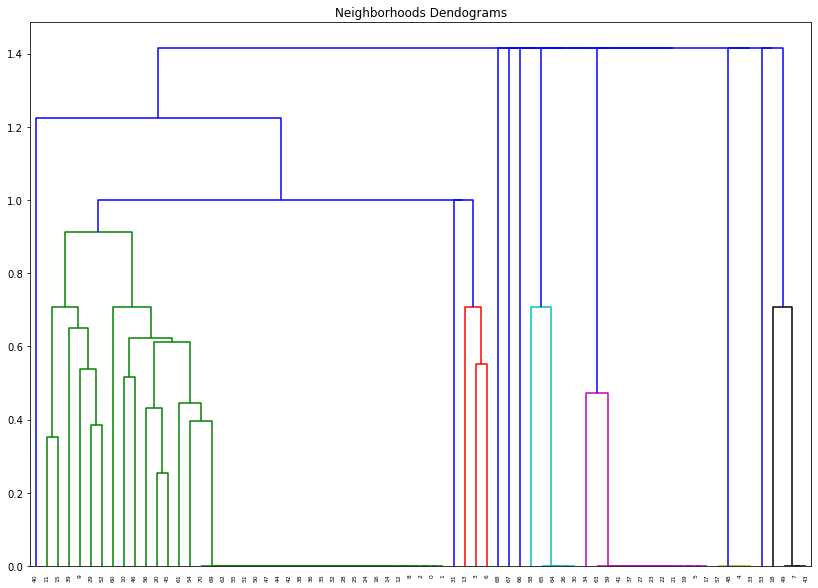

In [171]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))  
plt.title("Neighborhoods Dendograms")  
dend = shc.dendrogram(shc.linkage(cat_grouped, method='complete'))  
plt.show

### Analize which cluster is the better to invest, based on the near competition.

In [206]:
# grab the number of businesses in each cluster
clust0 = len(foodT_sd_merged.loc[foodT_sd_merged['Cluster Labels K-Means'] == 0])
clust1 = len(foodT_sd_merged.loc[foodT_sd_merged['Cluster Labels K-Means'] == 1])
clust2 = len(foodT_sd_merged.loc[foodT_sd_merged['Cluster Labels K-Means'] == 2])
clust3 = len(foodT_sd_merged.loc[foodT_sd_merged['Cluster Labels K-Means'] == 3])
clust4 = len(foodT_sd_merged.loc[foodT_sd_merged['Cluster Labels K-Means'] == 4])
cluster_list = [clust0, clust1, clust2, clust3, clust4]

### Report

In [211]:
df = pd.DataFrame(cluster_list, index=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
df.columns = ['# of Businesses']
df.columns.name = 'Cluster'
df

Cluster,# of Businesses
Cluster 0,5
Cluster 1,13
Cluster 2,10
Cluster 3,39
Cluster 4,4


#### Observations

Most of the fast food / food trucks businesses are concentrated in the Cluster 3, which is the north area of Santo Domingo, Distrito Nacional and a moderated number in Cluster 0 and Cluster 4. As much as Cluster 0 and Cluster 4 represents a great opportunity to open a new location as there is no intense competition due to high concentration of other fast food businesses.   

Therefore, this project recommends the investor to capitalize on these findings to open a new location in Cluster 0 or Cluster 4. Lastly, the investor is advised to avoid Cluster 3 which already have high concentrations of business alike and intense competition.